Importing Dataset

In [ ]:
%tensorflow_version

Currently selected TF version: 2.x
Available versions:
* 1.x
* 2.x


Disabling eager execution

In [ ]:
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()

Importing Essentials

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.image as img
from matplotlib.cm import get_cmap

Initializing :
We will bw using alphabeta rule for lower layers
1.   Using stabalising variable epsilon with alphabeta rule as per epsilon rule:<br>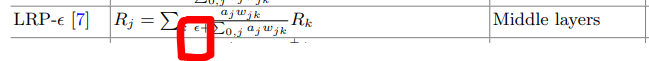
2.   Alpha Beta Rule for alphbeta rule:<br>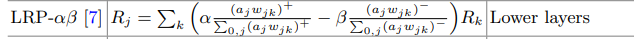
ref : https://link.springer.com/chapter/10.1007/978-3-030-28954-6_10

In [ ]:
eps = 1e-6
alpha = 0.7
beta = 1-alpha

In [ ]:
def get_relevance(model, upto_layer, input_layer =True):
    #model::Keras.Layer.Model -> model for whinch relevance needs to be propogated
    #uptolayer::int -> which layer relevance is required from top

    #Relevance of the output layer
    relevance = model.output

    #traversing model from the top
    for curr_layer in range(len(model.layers)-2, -1, -1):
        layer = model.layers[curr_layer+1]
        layer0 = model.layers[curr_layer]

        if curr_layer ==upto_layer:
            #print last two layer upto which
            print(layer.name, curr_layer+1)
            print(layer0.name, curr_layer)


            if input_layer ==True and upto_layer ==0 :
                relevance = for_input_layer(model.layers[1], model.layers[0], relevance)
            
            break
    
        if 'fc' in layer.name or 'predictions' in layer.name:
            relevance = for_dense_layer(layer, layer0, relevance)
        if 'flatten'  in layer.name:
            relevance = for_flatten_layer(layer, layer0, relevance)
        if 'conv' in layer.name:
            relevance = for_cnn_layer(layer, layer0, relevance)
        if 'pool' in layer.name:
            relevance = for_pooling_layer(layer, layer0, relevance)


    return relevance

#**LRP**
Basic rules:<br>
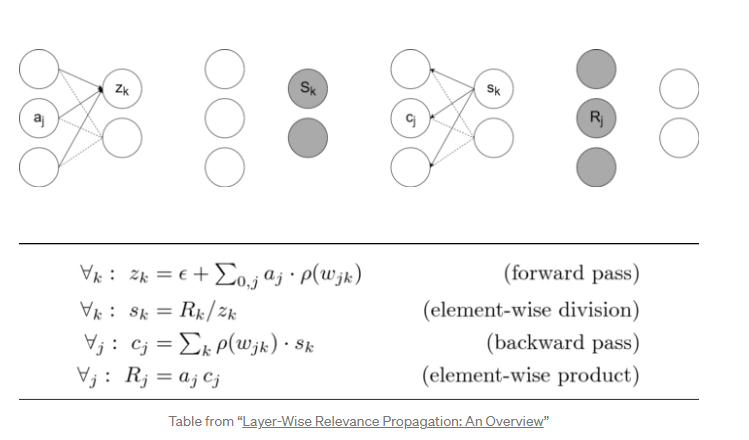
<br>
rule 0:<br>
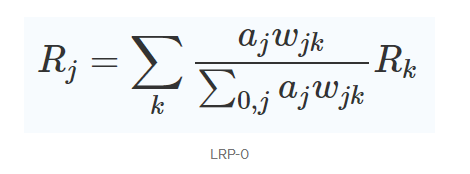
<br>
ref: https://towardsdatascience.com/indepth-layer-wise-relevance-propagation-340f95deb1ea

General steps
<br>
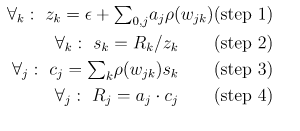

In [ ]:
def for_dense_layer(layer1, layer0, relevance):
    #layer1, layer0 :: Keras.Layers-> propagate relevance from layer1 to layer0
    weights = layer1.weights[0]
    baises = layer1.weights[1]
    activation = layer0.output
    
    pos_weights = tf.math.maximum(weights, 0)
    pos_baises = tf.math.maximum(baises, 0)

    pos_zk = eps+ tf.matmul(activation, pos_weights)+ pos_baises
    pos_sk = relevance/pos_zk
    pos_c = tf.matmul(pos_sk, tf.transpose(pos_weights))

    neg_weights = tf.math.minimum(weights, 0)
    neg_baises = tf.math.minimum(baises, 0)

    neg_zk = tf.matmul(activation, neg_weights) - neg_baises- eps
    neg_sk = relevance/neg_zk
    neg_c = tf.matmul(neg_sk, tf.transpose(neg_weights))

    cj = alpha*pos_c + beta*neg_c

    return activation*(cj)

In [ ]:
def for_flatten_layer(layer1, layer0, relevance):
    #layer1, layer0 :: Keras.Layers-> propagate relevance from layer1 to layer0
    #reshapes relavance as per next layer shape
    activation = layer0.output
    shape = activation.get_shape().as_list()
    shape[0] = -1
    return tf.reshape(relevance, shape)

Pseudocode
<br>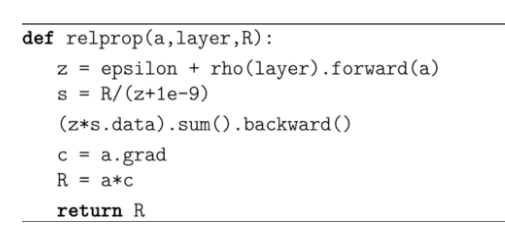

Step 3 using gradient
<br>
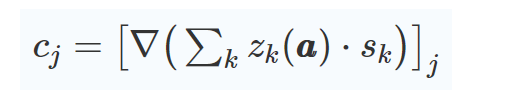


In [ ]:
def for_pooling_layer(layer1, layer0, relevance):
    activation = layer0.output

    ksize=[1,2,2,1]
    strides=[1,2,2,1]

    #step 1
    z = tf.nn.avg_pool2d(activation , ksize=ksize, strides= strides, padding='VALID')
    pos_z = tf.math.maximum(z, 0.) +eps
    r  = relevance

    #step 2 positive
    pos_s = r / pos_z

    #step 3 using gradients
    pos_c = tf.raw_ops.AvgPoolGrad(orig_input_shape = tf.shape(activation) , grad = pos_s, ksize=ksize, strides=strides, padding='VALID')

    neg_z = tf.math.minimum(z, 0.) +eps

    #step 2 negative
    neg_s = r / neg_z

    #step 3 using gradients
    neg_c = tf.raw_ops.AvgPoolGrad(orig_input_shape = tf.shape(activation), grad = neg_s, ksize=[1,2,2,1], strides=[1,2,2,1], padding='VALID')

    #using alphabeta rule
    cj = alpha*pos_c + beta*neg_c

    return activation*(cj)

In [ ]:
def for_cnn_layer(layer1, layer0, relevance):
    weights = layer1.get_weights()[0]
    baises = layer1.get_weights()[1]
    activation = layer0.output

    pos_weights = tf.maximum(weights,0)
    pos_baises = tf.maximum(baises, 0)

    #step 1
    pos_zk = eps+ tf.nn.conv2d(activation, filters=pos_weights, strides=[1,1,1,1], padding='SAME' )+ pos_baises

    #step 2
    pos_sk = relevance/pos_zk

    #step 3 using gradients
    #'input_sizes', 'filter', 'out_backprop', 'strides', 'padding', 'use_cudnn_on_gpu', 'explicit_paddings', 'data_format', 'dilations', 'name'
    pos_c = tf.raw_ops.Conv2DBackpropInput(input_sizes = tf.shape(activation), filter = pos_weights, out_backprop = pos_sk, strides=[1,1,1,1], padding='SAME')

    neg_weights = tf.math.minimum(weights, 0)
    neg_baises = tf.math.minimum(baises,0)

    #step 1
    neg_zk = eps+ tf.nn.conv2d(activation, filters=neg_weights, strides=[1,1,1,1], padding='SAME' )- neg_baises

    #step 2
    neg_sk = relevance/neg_zk

    #step 3 using gradients
    neg_c = tf.raw_ops.Conv2DBackpropInput(input_sizes = tf.shape(activation), filter = neg_weights, out_backprop = neg_sk, strides=[1,1,1,1], padding='SAME')

    #step 4
    cj = alpha*pos_c + beta*neg_c

    return activation*(cj)

In [ ]:
def for_input_layer(layer1, layer0, relevance):
    weights = layer1.get_weights()[0]
    baises = layer1.get_weights()[1]
    activation = layer0.output

    lb = tf.zeros(layer1.input_shape[1:])
    hb = tf.ones(layer1.input_shape[1:])
    
    lb = tf.expand_dims(lb, 0)
    hb = tf.expand_dims(hb, 0)

    pos_weights = tf.maximum(weights,0)
    pos_baises = tf.maximum(baises, 0)


    ##Weight
    #step 1
    zk = eps+ tf.nn.conv2d(activation, filters=weights, strides=[1,1,1,1], padding='SAME' )+ baises

    ##Pos Weight
    #step 1
    pos_zk = eps+ tf.nn.conv2d(hb, filters=pos_weights, strides=[1,1,1,1], padding='SAME' )+ pos_baises
    zk -=pos_zk

    #step 2
    pos_sk = relevance/pos_zk

    #step 3 using gradients
    #'input_sizes', 'filter', 'out_backprop', 'strides', 'padding', 'use_cudnn_on_gpu', 'explicit_paddings', 'data_format', 'dilations', 'name'
    pos_c = tf.raw_ops.Conv2DBackpropInput(input_sizes = tf.shape(hb) , filter = pos_weights, out_backprop = pos_sk, strides=[1,1,1,1], padding='SAME')

    ##Neg Weight
    neg_weights = tf.math.minimum(weights, 0)
    neg_baises = tf.math.minimum(baises,0)

    #step 1
    neg_zk = eps+ tf.nn.conv2d(lb, filters=neg_weights, strides=[1,1,1,1], padding='SAME' )- neg_baises
    zk -=neg_zk

    #step 2
    sk = relevance/zk

    #step 3 using gradients
    #'input_sizes', 'filter', 'out_backprop', 'strides', 'padding', 'use_cudnn_on_gpu', 'explicit_paddings', 'data_format', 'dilations', 'name'
    c = tf.raw_ops.Conv2DBackpropInput(input_sizes = tf.shape(activation), filter = weights, out_backprop = sk, strides=[1,1,1,1], padding='SAME')


    #step 2
    neg_sk = relevance/neg_zk

    #step 3 using gradients
    neg_c = tf.raw_ops.Conv2DBackpropInput(input_sizes = tf.shape(lb), filter = neg_weights, out_backprop = neg_sk, strides=[1,1,1,1], padding='SAME')


    #step 4
    cj = lb*pos_c + hb*neg_c

    return activation*c+cj

In [ ]:
def for_first_layer(layer1, layer0, relevance):
    weights = layer1.get_weights()[0]
    baises = layer1.get_weights()[1]
    activation = layer0.output

    lb = tf.zeros(layer1.input_shape[1:])
    hb = tf.ones(layer1.input_shape[1:])*255

    lb = tf.expand_dims(lb, 0)
    hb = tf.expand_dims(hb, 0)

    pos_weights = tf.maximum(weights,0)
    pos_baises = tf.maximum(baises, 0)


    ##Weight
    #step 1
    zk = eps+ tf.nn.conv2d(activation, filters=weights, strides=[1,1,1,1], padding='SAME' )+ baises

    #step 2
    sk = relevance/zk

    #step 3 using gradients
    #'input_sizes', 'filter', 'out_backprop', 'strides', 'padding', 'use_cudnn_on_gpu', 'explicit_paddings', 'data_format', 'dilations', 'name'
    c = tf.raw_ops.Conv2DBackpropInput(input_sizes = tf.shape(activation), filter = weights, out_backprop = sk, strides=[1,1,1,1], padding='SAME')

    ##Pos Weight
    #step 1
    pos_zk = eps+ tf.nn.conv2d(hb, filters=pos_weights, strides=[1,1,1,1], padding='SAME' )+ pos_baises

    #step 2
    pos_sk = relevance/pos_zk

    #step 3 using gradients
    #'input_sizes', 'filter', 'out_backprop', 'strides', 'padding', 'use_cudnn_on_gpu', 'explicit_paddings', 'data_format', 'dilations', 'name'
    pos_c = tf.raw_ops.Conv2DBackpropInput(input_sizes = tf.shape(hb) , filter = pos_weights, out_backprop = pos_sk, strides=[1,1,1,1], padding='SAME')

    ##Neg Weight
    neg_weights = tf.math.minimum(weights, 0)
    neg_baises = tf.math.minimum(baises,0)

    #step 1
    neg_zk = eps+ tf.nn.conv2d(lb, filters=neg_weights, strides=[1,1,1,1], padding='SAME' )- neg_baises

    #step 2
    neg_sk = relevance/neg_zk

    #step 3 using gradients
    neg_c = tf.raw_ops.Conv2DBackpropInput(input_sizes = tf.shape(lb), filter = neg_weights, out_backprop = neg_sk, strides=[1,1,1,1], padding='SAME')


    #step 4
    cj = lb*pos_c + hb*neg_c

    return activation*c+cj

In [ ]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input, decode_predictions

In [ ]:
model = VGG16()

553476096/553467096 [==============================] - 6s 0us/step


In [ ]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
relevance = get_relevance(model, 0)

block1_conv1 1
input_1 0


In [ ]:
relevance

<tf.Tensor 'add_154:0' shape=(None, 224, 224, 3) dtype=float32>

Creating LRP model

In [ ]:
LRP_model = tf.keras.backend.function(inputs=[model.input], outputs=[relevance,])

## Loading remote Image

In [ ]:
import urllib.request

url = "https://upload.wikimedia.org/wikipedia/commons/thumb/4/40/Panor%C3%A1mica_Oto%C3%B1o_Alc%C3%A1zar_de_Segovia.jpg/800px-Panor%C3%A1mica_Oto%C3%B1o_Alc%C3%A1zar_de_Segovia.jpg"
urllib.request.urlretrieve(url, "Castle.jpg")

('Castle.jpg', <http.client.HTTPMessage at 0x7f21c05c3350>)

In [ ]:
from keras.preprocessing.image import load_img

# load an image from file
image = load_img('Castle.jpg', target_size=(224, 224))

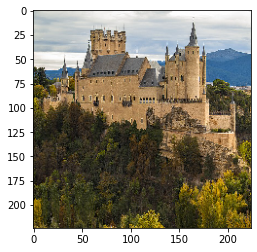

In [ ]:
plt.imshow(image)

Process the image

In [ ]:
from keras.preprocessing.image import img_to_array
import numpy as np

image = img_to_array(image)

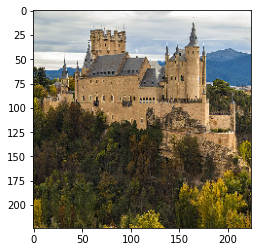

In [ ]:
plt.imshow(image)

In [ ]:
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
image = preprocess_input(image)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


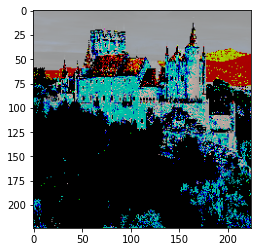

In [ ]:
plt.imshow(gamma_correction(image[0]/255, gamma = -0.1))

In [ ]:
pos_max = image[0].max(axis=-1)
neg_max = -((-image[0]).max(axis=-1))
reduced_channel = np.select([pos_max >= neg_max, pos_max < neg_max], [pos_max, neg_max])

In [ ]:
def gamma_correction(image, gamma=0.2, minamp=0, maxamp=None):
    c_image = np.zeros_like(image)
    image -= minamp

    if maxamp is None:
        maxamp = np.abs(image).max() + 1e-7
    image /= maxamp

    pos_mask = (image > 0)
    neg_mask = (image < 0)
    
    c_image[pos_mask] = np.power(image[pos_mask], gamma)
    c_image[neg_mask] = -np.power(-image[neg_mask], gamma)
    c_image = c_image * maxamp + minamp
    return c_image


# Runing the image model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


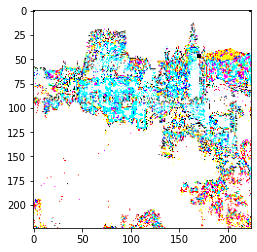

In [ ]:
lrp_img = LRP_model([image, ])[0]
plt.imshow(lrp_img[0])